In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math

In [3]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model=128, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
class TransformerTimeSeries(torch.nn.Module):
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,128,5)
        self.transformer_model = torch.nn.Transformer(nhead=16,num_encoder_layers=12,d_model=128)
        self.positional_embedding = PositionalEncoding(128,.1)
        self.fc1 = torch.nn.Linear(128,1)
        
    def forward(self,x_obs,x_future,y_obs,y_future,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z_obs = torch.cat((y_obs.unsqueeze(1),x_obs.unsqueeze(1)),1)
        z_future = torch.cat((y_future.unsqueeze(1),x_future.unsqueeze(1)),1)

        # input_embedding returns shape (B*embedding_size*n_time_points) -> need (n_time_points*B,embedding_size)
        z_obs_embedding = self.input_embedding(z_obs).permute(2,0,1)
        z_future_embedding = self.input_embedding(z_future).permute(2,0,1)
        
        # get my positional embeddings
        positional_embeddings = self.positional_embedding(torch.cat((z_obs_embedding,z_future_embedding),0))
        z_obs_embedding = positional_embeddings[0:z_obs_embedding.shape[0]]#self.positional_embedding(z_obs_embedding)
        z_future_embedding = positional_embeddings[z_obs_embedding.shape[0]:]#self.positional_embedding(z_future_embedding)
        
        transformer_embedding = self.transformer_model(z_obs_embedding,z_future_embedding,tgt_mask=attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
        

In [5]:
x = torch.randn([1,])

In [6]:
dataset = Dataloader.time_series_paper(96,5000)

x: 5000*120 fx: 5000*120


In [7]:
from torch.utils.data import DataLoader

In [8]:
criterion = torch.nn.MSELoss()

In [9]:
train_dl = DataLoader(dataset,batch_size=16,shuffle=True)

In [10]:
model = TransformerTimeSeries().cuda()

In [11]:
lr = .00005 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,10, gamma=0.95)

In [12]:
epochs = 50

In [13]:
model.train()
for epoch in range(epochs):
    epoch_loss = []
    for step,(x_obs,x_future,y_obs,y_future,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x_obs.cuda(),x_future.cuda(),y_obs.cuda(),y_future.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,:-1],y_future.cuda()[:,1:])
        epoch_loss.append(loss)
        
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        print("Epoch loss: {}".format(np.sum(epoch_loss)/len(train_dl)))
        
    scheduler.step()

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch loss: 1401.549560546875
Epoch loss: 172.41664123535156
Epoch loss: 52.538055419921875
Epoch loss: 34.91957092285156
Epoch loss: 26.842500686645508
Epoch loss: 21.998130798339844
Epoch loss: 19.362934112548828
Epoch loss: 18.351736068725586
Epoch loss: 15.80576229095459
Epoch loss: 15.630221366882324
Epoch loss: 13.205500602722168
Epoch loss: 12.558971405029297
Epoch loss: 12.247448921203613
Epoch loss: 11.916274070739746
Epoch loss: 11.41299057006836


KeyboardInterrupt: 

## Visualize the data

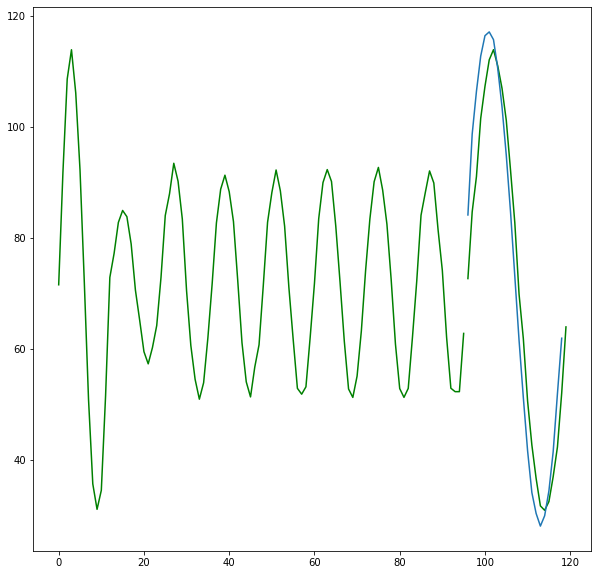

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


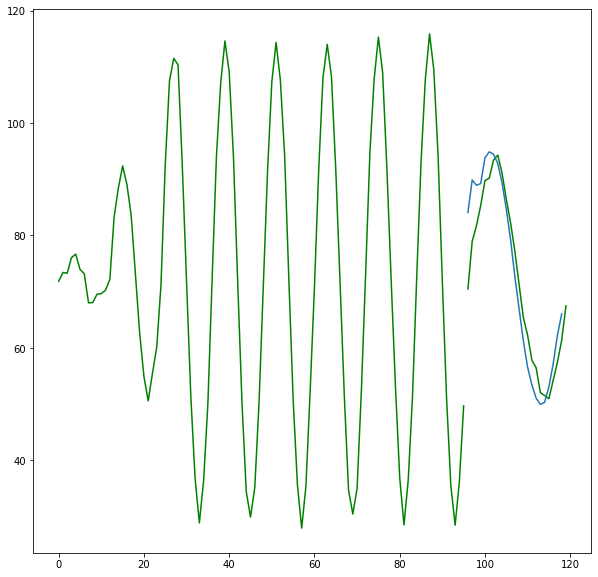

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


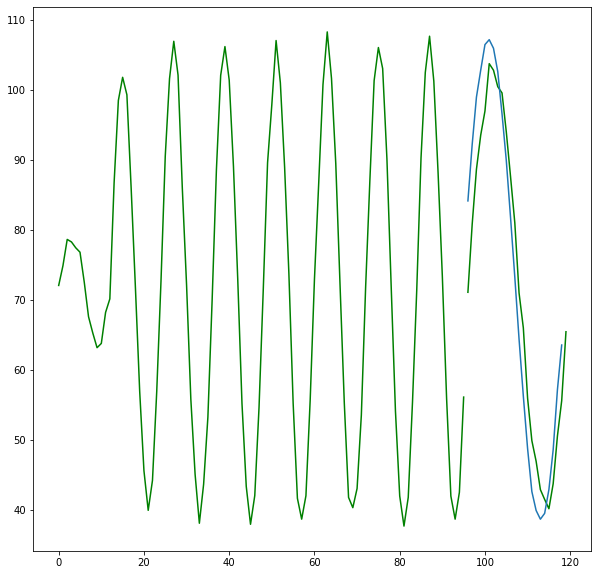

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


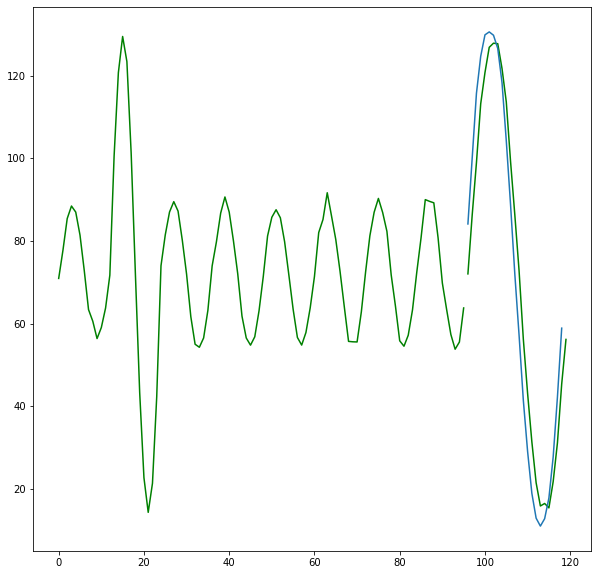

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


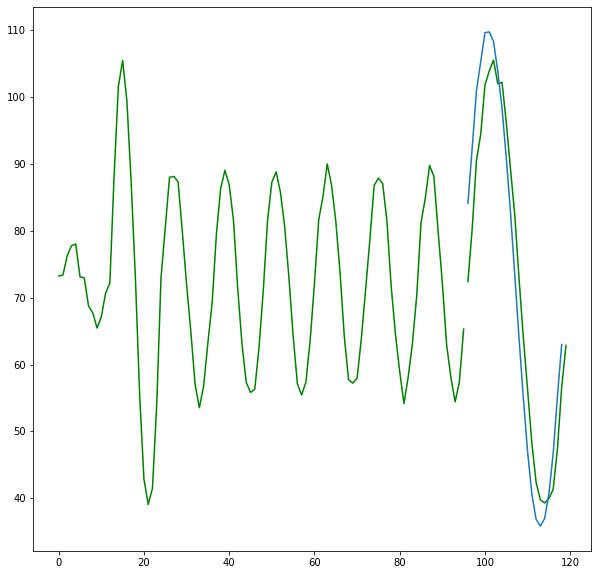

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


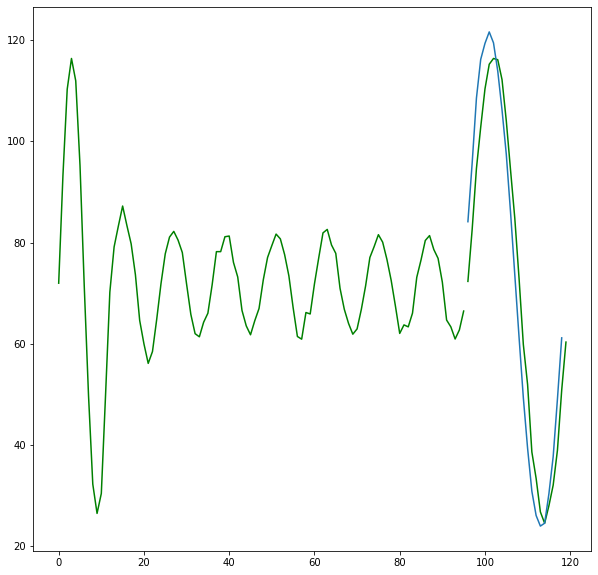

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


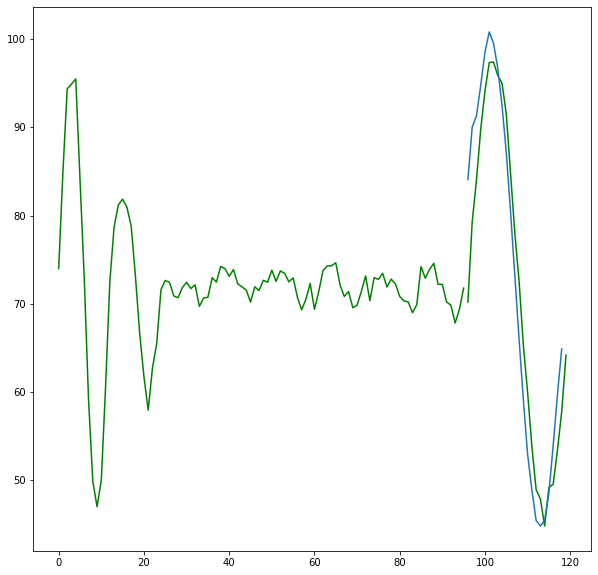

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


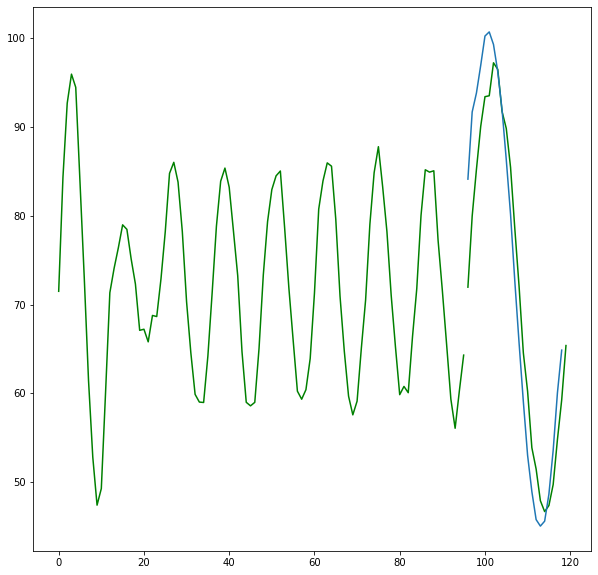

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


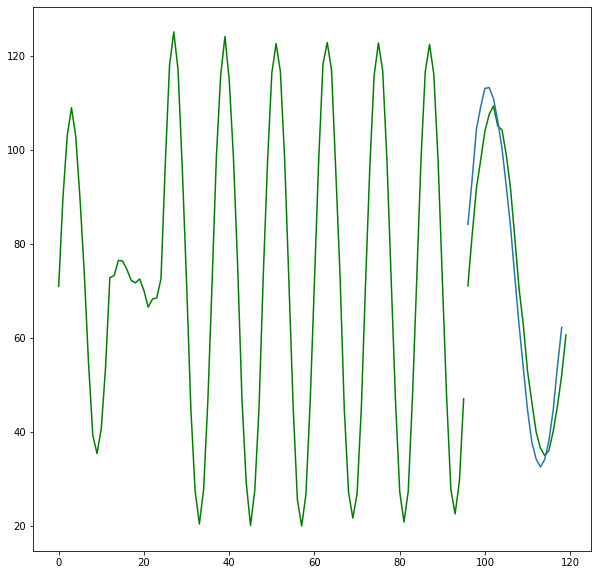

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


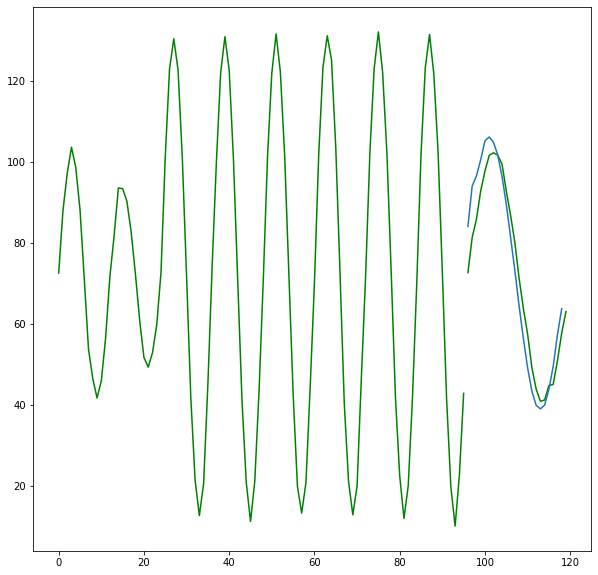

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


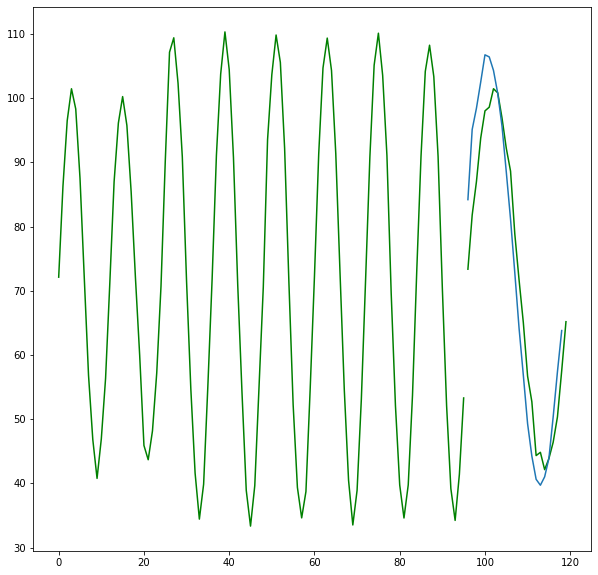

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [16]:
n_plots = 10
with torch.no_grad():
    model.eval()
    for step,(x_obs,x_future,y_obs,y_future,attention_masks) in enumerate(train_dl):
            output = model(x_obs.cuda(),x_future.cuda(),y_obs.cuda(),y_future.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x_future[0].cpu().detach().squeeze().numpy(),y_future[0].cpu().detach().squeeze().numpy(),'g-')
                plt.plot(x_obs[0].cpu().detach().squeeze().numpy(),y_obs[0].cpu().detach().squeeze().numpy(),'g-')

                plt.plot(x_future[0].cpu().detach().squeeze().numpy()[:-1],output[0].cpu().detach().squeeze().numpy()[:-1])
                plt.show()